# Multiclass Text Classification
- Data source: Bureau of Consumer Financial Protection (dataset is intended for public access and use)
- Dataset name: Consumer Complaint Database
- Link: https://catalog.data.gov/dataset/consumer-complaint-database

Goal:   **Assign a new complain to one of known categories.**

Dataset was reduced for illustration purpose.

# Load data and python libraries

In [1]:
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import json

# data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# features
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.decomposition import TruncatedSVD

# classifiers
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier

# metrics/evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score

from itertools import cycle

In [2]:
input_folder = './data/'
file_name = 'Consumer_Complaints.csv'

In [3]:
df_data = pd.read_csv(input_folder + file_name)

print('Length of the initial dataset:', len(df_data))
df_data.head().T

Length of the initial dataset: 1400730


,0,1,2,3,4
Date received,10/07/2019,10/07/2019,10/07/2019,10/07/2019,10/07/2019
Product,"Credit reporting, credit repair services, or o...",Mortgage,Debt collection,"Credit reporting, credit repair services, or o...","Money transfer, virtual currency, or money ser..."
Sub-product,Credit reporting,Conventional home mortgage,I do not know,Credit reporting,International money transfer
Issue,Incorrect information on your report,Trouble during payment process,Communication tactics,Incorrect information on your report,Other transaction problem
Sub-issue,Account information incorrect,NaN,Frequent or repeated calls,Account information incorrect,NaN
Consumer complaint narrative,NaN,NaN,NaN,NaN,NaN
Company public response,NaN,NaN,Company believes it acted appropriately as aut...,Company has responded to the consumer and the ...,NaN
Company,"ONEMAIN FINANCIAL HOLDINGS, LLC.",NAVY FEDERAL CREDIT UNION,"ATG Credit, LLC","Ability Recovery Services, LLC",NAVY FEDERAL CREDIT UNION
State,MN,DC,FL,WI,NaN
ZIP code,55128,20002,32907,54727,NaN


##### Observations:

Texts of complains are in 3 columns "Issue", "Sub-issue" and "Consumer complaint narrative".

Since we want to work with only unstructured and unknown complains, only "Consumer complaint narrative" is considered.



In [4]:
# data for analysis
df_data = df_data[df_data['Consumer complaint narrative'].isnull() == False][['Product', 
                                                                              'Consumer complaint narrative']]
len(df_data)

447914

In [5]:
# labels (product categories) 
df_data['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    123831
Debt collection                                                                  98476
Mortgage                                                                         58139
Credit reporting                                                                 31588
Credit card or prepaid card                                                      27658
Student loan                                                                     23824
Credit card                                                                      18838
Checking or savings account                                                      16653
Bank account or service                                                          14885
Consumer Loan                                                                     9473
Vehicle loan or lease                                                             7169
Money transfer, virtual currency, or money 

In [6]:
# making "Credit reporting, credit repair services, or other personal consumer reports" and 
# "Credit reporting" as one category "Personal consumer reports"

df_data['Product'] = df_data['Product'].str.replace("Credit reporting, credit repair services, or other personal consumer reports", 
                                                    "Personal consumer reports")
df_data['Product'] = df_data['Product'].str.replace("Credit reporting", 
                                                    "Personal consumer reports")

##### Just for the illustration:
only 600 of random observations from top 4 product categories are selected
500 for model training/testing and 100 for model evaluation on unseen data

In [7]:
# selecting only top 4 product categories 
selected_products= ["Personal consumer reports",
                   "Debt collection",
                   "Mortgage",
                   "Credit card or prepaid card"]

In [8]:
# selecting 600 random records of each type of selected products
df_train_list = []
df_evaluate_list = []

for product in selected_products:
    df_tmp = df_data[df_data['Product'] == product].sample(n=600, random_state=1)
    df_train_list.append(df_tmp.iloc[100:])
    df_evaluate_list.append(df_tmp.iloc[:100])

df = pd.concat(df_train_list) 
df_eval = pd.concat(df_evaluate_list) 

print('TRAIN Dataset length:', len(df))
print('\nComplain categories and counts:')
print(df['Product'].value_counts())

print('\n\nEVALUATION Dataset length:', len(df_eval))
print('\nComplain categories and counts:')
print(df_eval['Product'].value_counts())

TRAIN Dataset length: 2000

Complain categories and counts:
Credit card or prepaid card    500
Mortgage                       500
Personal consumer reports      500
Debt collection                500
Name: Product, dtype: int64


EVALUATION Dataset length: 400

Complain categories and counts:
Credit card or prepaid card    100
Mortgage                       100
Personal consumer reports      100
Debt collection                100
Name: Product, dtype: int64


In [9]:
# consumer complaint narrative text length analysis
df['text'] = df['Consumer complaint narrative']
df['text'] = df['text'].fillna('')
df['Text Length in Characters'] = df['text'].apply(len)


print("Text Length in Characters:")
df.groupby('Product')['Text Length in Characters'].describe()

Text Length in Characters:


,count,mean,std,min,25%,50%,75%,max
Product,,,,,,,,
Credit card or prepaid card,500.0,1294.414,1330.963005,29.0,528.75,942.0,1540.5,10346.0
Debt collection,500.0,860.398,890.494402,14.0,314.00,604.0,1061.5,8299.0
Mortgage,500.0,1794.542,2531.987086,83.0,702.50,1253.0,2111.5,28935.0
Personal consumer reports,500.0,805.640,950.851797,18.0,269.00,531.5,996.5,7940.0


# Preparing data for classification

In [10]:
# turning labels into numbers
LE = LabelEncoder()
df['Product_num'] = LE.fit_transform(df['Product'])
df_eval['Product_num'] = LE.transform(df_eval['Product'])

ts_tmp = df.groupby('Product')['Product_num'].min()
dict_product_id = ts_tmp.to_dict()
pd.DataFrame(ts_tmp) 

,Product_num
Product,
Credit card or prepaid card,0
Debt collection,1
Mortgage,2
Personal consumer reports,3


In [11]:
ts_tmp = df_eval.groupby('Product')['Product_num'].min()
pd.DataFrame(ts_tmp)

,Product_num
Product,
Credit card or prepaid card,0
Debt collection,1
Mortgage,2
Personal consumer reports,3


##### TfidfVectorizer parameters
- sublinear_df is set to True to use a logarithmic form for frequency.
- min_df is the minimum numbers of documents a word must be present in to be kept.
- norm is set to l2, to ensure all our feature vectors have a Euclidian norm of 1.
- ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams.
- stop_words is set to "English" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features.
- delete corpus-specific stop words (words/phrases that have appear in more than 95% of documents) 

In [12]:
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, 
                                    min_df=5, max_df=0.95, norm='l2', 
                                    encoding='latin-1', ngram_range=(1, 2), 
                                    stop_words='english')

In [13]:
# data for model train/test
X = tfidf_vectorizer.fit_transform(df['Consumer complaint narrative']).toarray() #features
y = df['Product_num'].values #target

# data for model evaluation
X_eval = tfidf_vectorizer.transform(df_eval['Consumer complaint narrative']).toarray() #features
y_eval = df_eval['Product_num'].values #target

print('Data shapes for model selection:')
print ('X:', X.shape)
print('y:', y.shape)

print('\nData shapes for model evaluation:')
print ('X_eval:', X_eval.shape)
print('y_eval:', y_eval.shape)

Data shapes for model selection:
X: (2000, 6439)
y: (2000,)

Data shapes for model evaluation:
X_eval: (400, 6439)
y_eval: (400,)


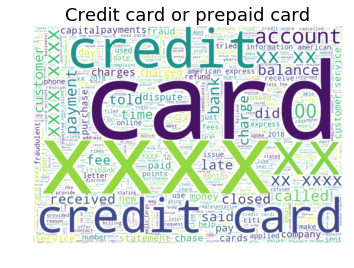

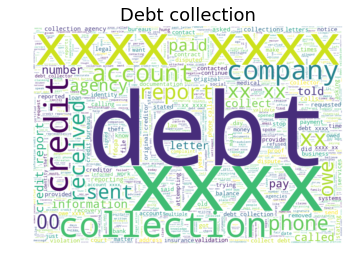

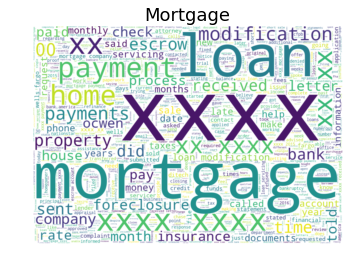

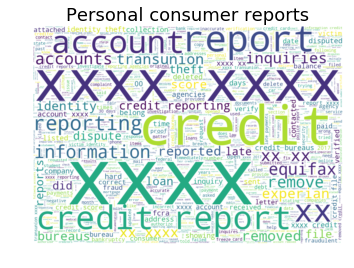

In [14]:
# looking at words/2_words_phrases that are used for classification
# generate the wordcloud for each product category

df_X = pd.DataFrame(X, columns=tfidf_vectorizer.get_feature_names())
df_X['Product_num'] = y

wordcloud = WordCloud(
    background_color="white",
    max_words=2000,
    width=1024,
    height=720
)

for product, num in dict_product_id.items():
    
    df_num = df_X[df_X['Product_num'] == num].sum(axis=0).iloc[:-1]
    word_weights = df_num.to_dict()
    
    wordcloud.generate_from_frequencies(word_weights)

    # display the generated image:
    plt.figure()
    plt.title(product, fontsize = 18)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [15]:
# dimensionality reduction
# using LSA (Truncated Singular Value Decomposition) to reduce the number of dimensions and select the best ones.
# Only using the 100 best features per category.

lsa = TruncatedSVD(n_components=100, 
                   n_iter=10, 
                   random_state=3)

X = lsa.fit_transform(X)
X_eval = lsa.transform(X_eval)

print('X shape after LSA for model selection:')
print ('X:', X.shape)

print('\nX_eval shape after LSA for model evaluation:')
print ('X_eval:', X_eval.shape)

X shape after LSA for model selection:
X: (2000, 100)

X_eval shape after LSA for model evaluation:
X_eval: (400, 100)


# Model Selection

In [16]:
# train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)

In [17]:
# creating a dict of models
model_dict = {'Random Choice' : DummyClassifier(),
              'Stochastic Gradient Descent' : SGDClassifier(),
              'Random Forest': RandomForestClassifier(),
              'AdaBoost': AdaBoostClassifier(),
              'Gaussian Naive Bayes': GaussianNB()}

In [18]:
# creating a dict of parameters for the models
params_SGD = dict(loss=['log'],
                  penalty=['l2','l1'],
                  alpha=[1e-6, 1e-3, 1e-1, 1e0],
                  max_iter=[5, 1000, 10000],
                  tol=[None, 1e-3],
                  random_state=[3])
params_RF = dict(bootstrap = [True, False],
                  max_depth = [10, 50, 100, None],
                  max_features = ['auto', 'sqrt'],
                  min_samples_leaf = [1, 2, 4],
                  n_estimators = [500, 1000],
                  random_state=[3])
params_AB = dict(base_estimator=[DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2)],
                learning_rate=[1, 1.5, 2],
                n_estimators=[100, 200],
                algorithm=["SAMME", "SAMME.R"],
                random_state=[3])


parameters_dict = {'Random Choice' : {},
                  'Stochastic Gradient Descent' : params_SGD,
                  'Random Forest': params_RF,
                  'AdaBoost': params_AB,
                  'Gaussian Naive Bayes': {}}

In [ ]:
# NOTE: it will take time
# gridsearch can be done on a virtual machine s.a. DataLab.
# Since labels (Product categories) are balanced use accuracy to tune and compare models

model_name, model_parameters, model_best_score = [], [], []

model_names = model_dict.keys()

for MN in model_names:
    print("="*45)
    print(MN)
    clf = model_dict[MN]
    params = parameters_dict[MN]

    gridsearch = GridSearchCV(clf,
                              params,
                              cv=5,
                              verbose=1, 
                              n_jobs=10)
    
    best_model = gridsearch.fit(X, y)
    model_name.append(MN)
    model_parameters.append(gridsearch.best_params_)
    model_best_score.append(gridsearch.best_score_ )

In [20]:
# comparing different models
model_comparison_df = pd.DataFrame([model_name, model_best_score, model_parameters]).T
model_comparison_df.columns = ['model_name', 'accuracy_score','parameters']

model_comparison_df = model_comparison_df.sort_values(by='accuracy_score', ascending=False)
clf_name = model_comparison_df['model_name'].iloc[0]
clf_params = model_comparison_df['parameters'].iloc[0]
clf_accuracy = model_comparison_df['accuracy_score'].iloc[0]

print('Best model:', clf_name)
model_comparison_df[['model_name', 'accuracy_score']]

Best model: Stochastic Gradient Descent


,model_name,accuracy_score
1,Stochastic Gradient Descent,0.864
2,Random Forest,0.8495
3,AdaBoost,0.8305
4,Gaussian Naive Bayes,0.776
0,Random Choice,0.252


In [21]:
# getting predictions from the best model
# train test split with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)

clf = model_dict[clf_name]
clf.set_params(**clf_params)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

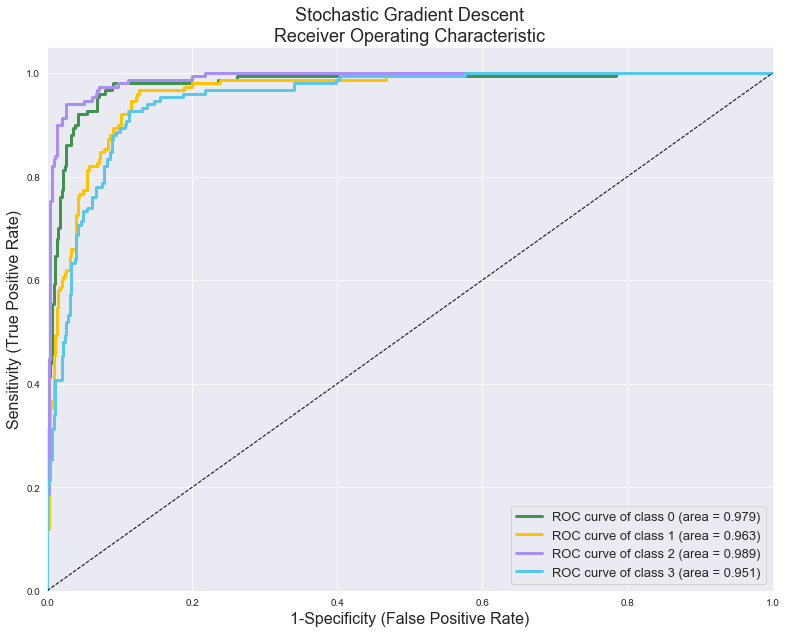

In [22]:
# plotting  AUC

# binarize labels (product categories)
y_b = label_binarize(y, classes = [0, 1, 2, 3])
n_classes = y_b.shape[1]

# shuffle and split training and test sets with stratified sampling and binarized labels
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X,
                                                            y_b,
                                                            test_size = .3,
                                                            shuffle = True,
                                                            stratify = y,
                                                            random_state = 3)

# learn to predict each class against the other
classifier = OneVsRestClassifier(clf)

y_score = classifier.fit(X_train_b, y_train_b).predict_proba(X_test_b)

# compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(13,10)) 
sns.set_style('darkgrid')

colors = cycle(['#41924F', '#FFC300', '#a98ff3', '#59C7EA'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], 
             color=color, 
             lw=3, 
             label='ROC curve of class {0} (area = {1:0.3f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity (False Positive Rate)', fontsize = 16)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize = 16)
plt.title(clf_name + '\nReceiver Operating Characteristic', fontsize = 18)
plt.legend(loc="lower right", fontsize = 13)
plt.show()

# Model Evaluation

In [23]:
# get predictions from the best model using unseen data
y_pred = clf.predict(X_eval)

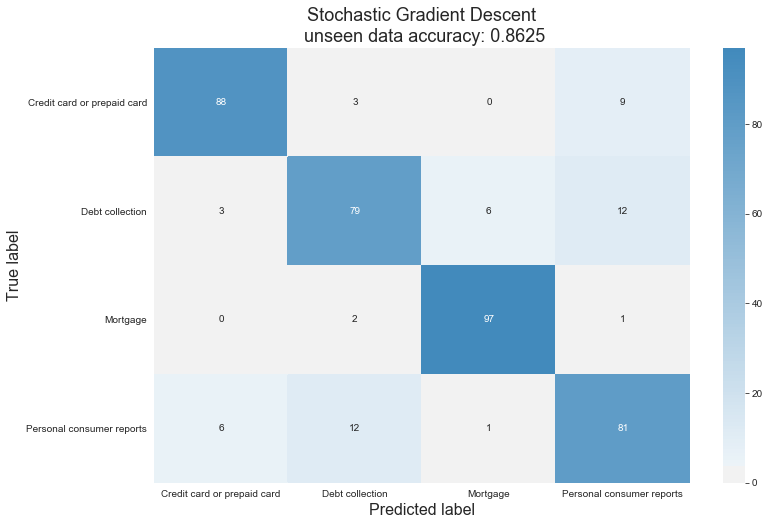

In [24]:
# confusion matrix
cm = confusion_matrix(y_eval, y_pred) 

cm_df = pd.DataFrame(cm,
                     index = ['Credit card or prepaid card',
                              'Debt collection','Mortgage', 
                              'Personal consumer reports'],                      
                     columns = ['Credit card or prepaid card',
                              'Debt collection','Mortgage', 
                              'Personal consumer reports'])

# plot the heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(cm_df, 
            center=0, 
            cmap=sns.diverging_palette(10, 240, s=80, l=55, as_cmap=True), 
            annot=True, 
            fmt='g')

plt.title(clf_name + '\n unseen data accuracy: ' + str(accuracy_score(y_eval, y_pred)), fontsize = 18)
plt.ylabel('True label', fontsize = 16)
plt.xlabel('Predicted label', fontsize = 16)
plt.show()